# Коронавирус COVID19


Этот Jupyter-блокнот посвящен исследованию вопроса распространения коронавируса. Датасет взят [со страницы Kaggle](https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset#2019_nCoV_data.csv).

Подробнее – читайте в статье на proglib.io.

## Импортируем библиотеки и изучаем данные

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# считаем данные из csv файла
data = pd.read_csv("2019_nCoV_data.csv")

data.shape

(1719, 8)

На текущий момент (19 февраля) набор данных состоит из 1719 строк и 8 столбцов. Посмотрим на структуру файла, выведем первые 5 строк.

In [2]:
data.head()

,Sno,Date,Province/State,Country,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020 12:00:00,Anhui,China,01/22/2020 12:00:00,1.0,0.0,0.0
1,2,01/22/2020 12:00:00,Beijing,China,01/22/2020 12:00:00,14.0,0.0,0.0
2,3,01/22/2020 12:00:00,Chongqing,China,01/22/2020 12:00:00,6.0,0.0,0.0
3,4,01/22/2020 12:00:00,Fujian,China,01/22/2020 12:00:00,1.0,0.0,0.0
4,5,01/22/2020 12:00:00,Gansu,China,01/22/2020 12:00:00,0.0,0.0,0.0


Столбец `Sno` выглядит как номер строки и не имеет значения для анализа. В столбце `Last Update` отображены те же значения, что и в столбце `Date`, за исключением нескольких случаев, когда числа обновлялись позже. Удалим столбцы `Sno` и `Last Update`. Посмотрим, какие данные предоставляют оставшиеся 6 столбцов.

In [3]:
data.drop(["Sno", "Last Update"], axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1719 entries, 0 to 1718
Data columns (total 6 columns):
Date              1719 non-null object
Province/State    1257 non-null object
Country           1719 non-null object
Confirmed         1719 non-null float64
Deaths            1719 non-null float64
Recovered         1719 non-null float64
dtypes: float64(3), object(3)
memory usage: 80.7+ KB


Кроме `Province/State` все столбцы целиком заполнены. Это объясняется тем, что для ряда стран, например, России, указана только страна, без указания области.

Перейдем к числовым столбцам с категориями заболевших. Метод `describe` описывает общую статистику для каждого числового столбца (с типом `float64`).

In [4]:
data.describe()

,Confirmed,Deaths,Recovered
count,1719.000000,1719.000000,1719.000000
mean,454.596859,10.441536,44.361838
std,3712.529032,106.638286,351.078713
min,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000
50%,12.000000,0.000000,0.000000
75%,109.000000,0.000000,7.000000
max,59989.000000,1789.000000,7862.000000


Из значений `max` видно, что данные в столбцах – кумулятивные. То есть в каждый день дается итог с накопллением. Датасет на Kaggle несколько отстает от данных в исходных CSV-файлах на GitHub (здесь мы видим 60 тыс. общих случаев против 75 тыс. текущих). Но для общего анализа зависимостей это не так важно.

Проверим данные на дубликаты. Метод `duplicated()` возвращает серию логических значений (значения равны `True`, если аналогичная строка уже имеется в наборе данных). Проверим, что выходные данные показывают, что никакие две записи не имеют одинаковую страну, область и дату.

In [5]:
sum(data.duplicated(['Country', 'Province/State', 'Date']))

0

Отлично, дубликатов не найдено – сумма булевых значений может быть равна нулю только если все значения `False`. Получается, что все значения набора данных уникальны.

Найдем все страны, в которых были зарегистрированы случаи обнаружения коронавируса.

При предварительном анализе мы заметили, что в одних сообщениях указан просто Китай (`China`), в других – [Континентальный Китай](https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D0%BD%D1%82%D0%B8%D0%BD%D0%B5%D0%BD%D1%82%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B9_%D0%9A%D0%B8%D1%82%D0%B0%D0%B9) без Гонконга и Макао (`Mainland China`). Объединим данные для анализа и выведем список стран.

In [6]:
data.loc[data['Country'] == 'Mainland China', 'Country'] = 'China'

country_list = data['Country'].unique()
print('Коронавирус COVID19 обнаружен в {} странах:'.format(country_list.size))

for country in sorted(country_list):
    print('- {}'.format(country))

Коронавирус COVID19 обнаружен в 33 странах:
- Australia
- Belgium
- Brazil
- Cambodia
- Canada
- China
- Egypt
- Finland
- France
- Germany
- Hong Kong
- India
- Italy
- Ivory Coast
- Japan
- Macau
- Malaysia
- Mexico
- Nepal
- Others
- Philippines
- Russia
- Singapore
- South Korea
- Spain
- Sri Lanka
- Sweden
- Taiwan
- Thailand
- UK
- US
- United Arab Emirates
- Vietnam


Можно видеть, что среди стран указаны `Others`:

In [7]:
data[data['Country'] == 'Others']

,Date,Province/State,Country,Confirmed,Deaths,Recovered
937,02/07/2020 20:24:00,Cruise Ship,Others,61.0,0.0,0.0
1009,02/08/2020 23:04:00,Cruise Ship,Others,61.0,0.0,0.0
1081,02/09/2020 23:20:00,Diamond Princess cruise ship,Others,64.0,0.0,0.0
1147,02/10/2020 19:30:00,Diamond Princess cruise ship,Others,135.0,0.0,0.0
1219,02/11/2020 20:44:00,Diamond Princess cruise ship,Others,135.0,0.0,0.0
1290,02/12/2020 22:00:00,Diamond Princess cruise ship,Others,175.0,0.0,0.0
1363,02/13/2020 21:15:00,Diamond Princess cruise ship,Others,218.0,0.0,0.0
1437,02/14/2020 22:00:00,Diamond Princess cruise ship,Others,218.0,0.0,0.0
1510,02/15/2020 22:00:00,Diamond Princess cruise ship,Others,285.0,0.0,0.0
1582,02/16/2020 22:00:00,Diamond Princess cruise ship,Others,355.0,0.0,0.0


То есть эти случаи произошли не в странах, а на большом круизном судне, имени которого вначале  не знали, а потом было определено, что это круизный лайнер Diamond Princess («Бриллиантовая принцесса»). 

Россиянин Аркадий Булгатов вместе с другими пассажирами оказался в «Карантине» на этом корабле. Его заметку о том, что проходило на корабле вы можете прочитать онлайн в [журнале Esquire](https://esquire.ru/articles/157033-rezhim-karantin-kolonka-rossiyanina-kotoryy-okazalsya-zapert-na-zarazhennom-koronavirusom-laynere-diamond-princess/). Карантин был [снят 19 февраля](https://meduza.io/news/2020/02/19/v-yaponii-na-kruiznom-laynere-daymond-prinsess-snyali-karantin-po-koronavirusu-pervye-rossiyane-soshli-na-bereg).

Посмотрим на ситуацию по России, отраженную в агрегированных данных.

In [8]:
data[data['Country'] == 'Russia']

,Date,Province/State,Country,Confirmed,Deaths,Recovered
494,01/31/2020 19:00:00,NaN,Russia,2.0,0.0,0.0
545,02/01/2020 23:00:00,NaN,Russia,2.0,0.0,0.0
614,02/02/2020 21:00:00,NaN,Russia,2.0,0.0,0.0
681,02/03/2020 21:40:00,NaN,Russia,2.0,0.0,0.0
750,02/04/2020 22:00:00,NaN,Russia,2.0,0.0,0.0
820,02/05/2020 12:20:00,NaN,Russia,2.0,0.0,0.0
891,02/06/2020 20:05:00,NaN,Russia,2.0,0.0,0.0
964,02/07/2020 20:24:00,NaN,Russia,2.0,0.0,0.0
1036,02/08/2020 23:04:00,NaN,Russia,2.0,0.0,0.0
1108,02/09/2020 23:20:00,NaN,Russia,2.0,0.0,0.0


Стабильно указаны 2 пациента, которые по сведениям датасета после 11 февраля были признаны выздоровевшими. Действительно, 12 февраля Газета.ру [написала](https://www.gazeta.ru/social/2020/02/11/12955699.shtml), о том, что в Чите выздоровел второй человек в России, болевший коронавирусом: гражданину КНР Ван Юньбиню вручили документы о выписке.



Проанализируем как часто поступают данные. 

In [9]:
print(list(data['Date'].unique()))

['01/22/2020 12:00:00', '01/23/2020 12:00:00', '01/24/2020 12:00:00', '01/25/2020 22:00:00', '01/26/2020 23:00:00', '01/27/2020 20:30:00', '01/28/2020 23:00:00', '01/29/2020 21:00:00', '01/30/2020 21:30:00', '01/31/2020 19:00:00', '02/01/2020 23:00:00', '02/02/2020 21:00:00', '02/03/2020 21:40:00', '02/04/2020 22:00:00', '02/05/2020 12:20:00', '02/06/2020 20:05:00', '02/07/2020 20:24:00', '02/08/2020 23:04:00', '02/09/2020 23:20:00', '02/10/2020 19:30:00', '02/11/2020 20:44:00', '02/12/2020 22:00:00', '02/13/2020 21:15:00', '02/14/2020 22:00:00', '02/15/2020 22:00:00', '02/16/2020 22:00:00', '02/17/2020 22:00:00']


Итак, данные ведут отсчет с 22 января. Время разнится от даты к дате. Приведем даты к единообразному представлению.

In [10]:
data['Date'] = pd.to_datetime(data['Date'])
data['Date_date'] = data['Date'].apply(lambda x:x.date())
df_by_date=data.groupby(['Date_date']).sum().reset_index(drop=None)

Посмотрим, как повлияла эпидемия на каждую страну.

In [11]:
df_country=data.groupby(['Country']).max().reset_index(drop=None).sort_values(by='Confirmed', ascending=False)
df_country[['Country','Confirmed','Deaths','Recovered']]

,Country,Confirmed,Deaths,Recovered
5,China,59989.0,1789.0,7862.0
19,Others,454.0,0.0,0.0
22,Singapore,77.0,0.0,24.0
14,Japan,66.0,1.0,12.0
10,Hong Kong,60.0,1.0,2.0
28,Thailand,35.0,0.0,15.0
23,South Korea,30.0,0.0,10.0
16,Malaysia,22.0,0.0,7.0
27,Taiwan,22.0,1.0,2.0
32,Vietnam,16.0,0.0,7.0


Данные подтверждают, что в Китае зарегистрировано наибольшее количество зарегистрированных случаев и основное число смертельных случаев. Кроме Китая, очаг незначительно перекинулся на другие страны Восточной Азии. Первая смерть среди стран Европы, произошла во Франции. 

# Визуализируем данные

Для визуализации данных мы используем две библиотеки Python – Matplotlib и Seaborn. Matplotlib – библиотека 2D-визуализации, используемая большинством исследователей данных. Seaborn построен поверх matplotlib, помогает создавать более привлекательные и сложные представления, такие как тепловые карты.

## Временная зависимость количества подтвержденных случаев

Для начала проверим, что используемые на сайте данные соответствуют тем, что мы взяли с Kaggle, и есть ли на данных тот же скачок.

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


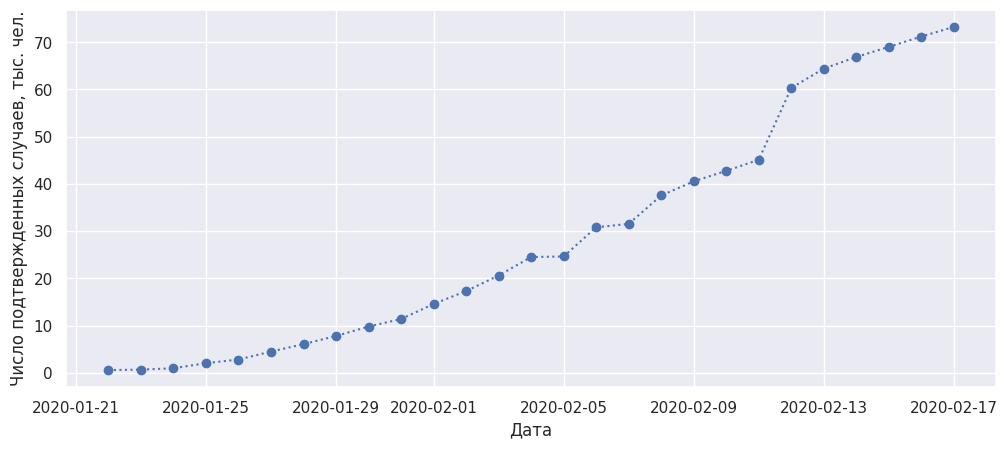

In [12]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [12.0, 5.0]
mpl.rcParams['figure.dpi'] = 100

sns.set()
plt.plot(df_by_date["Date_date"],
         df_by_date["Confirmed"]/1000,
         'o:')

plt.xlabel('Дата')
plt.ylabel('Число подтвержденных случаев, тыс. чел.')
plt.show()

Да, скачок есть, всё соответствует данным с сайта, но теперь мы можем оформлять данные в своем стиле.

## Число умерших и выздоровевших

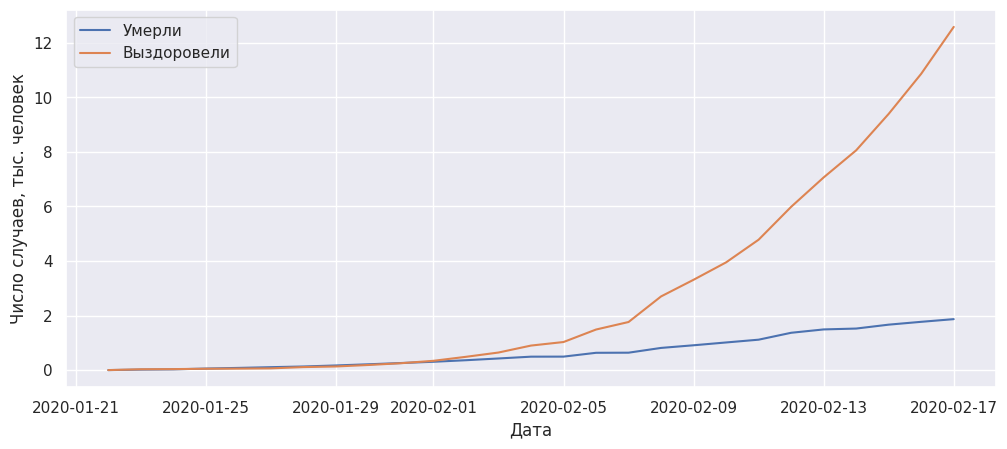

In [13]:
d = {"Deaths":"Умерли", "Recovered":"Выздоровели"}

for label in d:
    plt.plot(df_by_date["Date_date"],
             df_by_date[label]/1000,
             label=d[label])

plt.ylabel('Число случаев, тыс. человек')
plt.xlabel('Дата')
plt.legend()
plt.show()

Видно, что сейчас наблюдается рост обеих групп с превышением числа выздоровевших пациентов. Так как изменение составляет порядки величины, построим данные в полулогарифмическом масштабе.

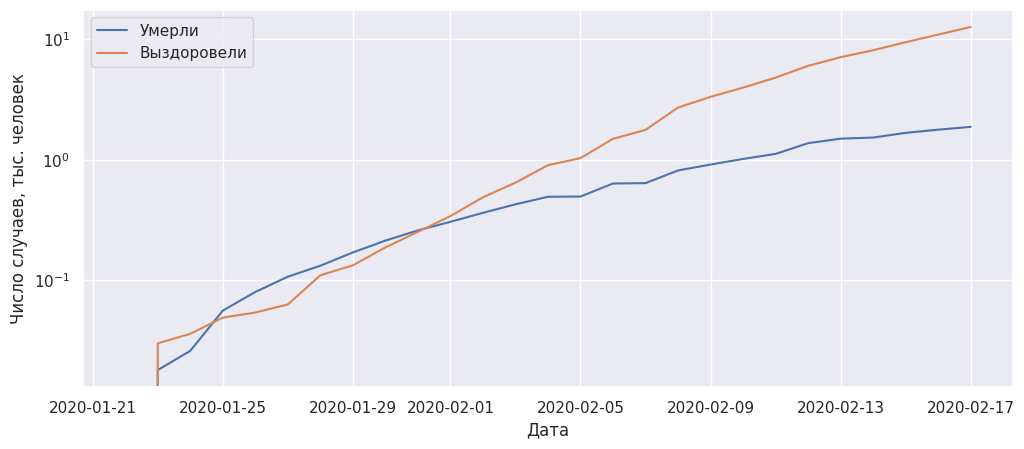

In [14]:
plt.yscale('log')
for label in d:
    plt.plot(df_by_date["Date_date"],
             df_by_date[label]/1000,
             label=d[label])

plt.ylabel('Число случаев, тыс. человек')
plt.xlabel('Дата')
plt.legend()
plt.show()

Можно видеть, что число выздоровевших пациентов начало превышать число умирающих в начале февраля.

## Грубая оценка летальности

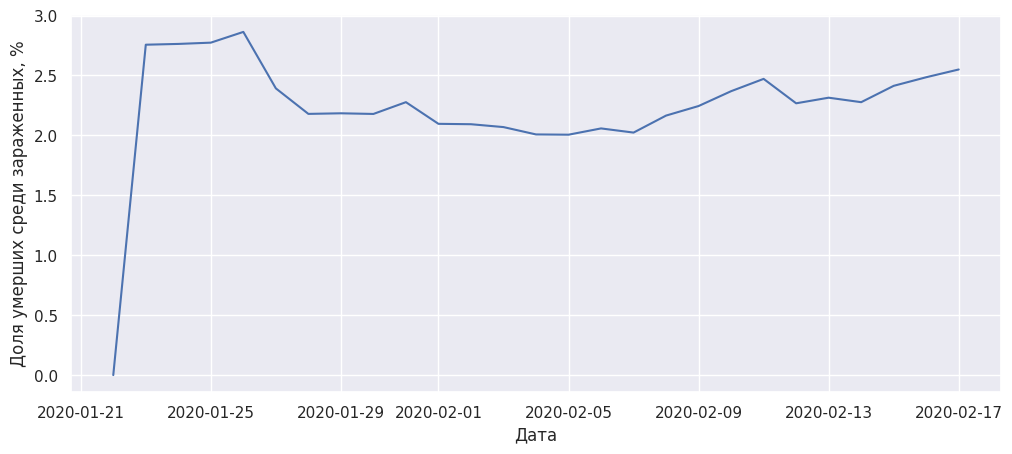

In [15]:
plt.plot(df_by_date["Date_date"],
         df_by_date['Deaths']/df_by_date['Confirmed']*100)

plt.ylabel('Доля умерших среди зараженных, %')
plt.xlabel('Дата')
plt.show()

Текущие значения колеблются между 2 и 3%. Сравним рассмотренную динамику смертности с динамикой выздоровления.

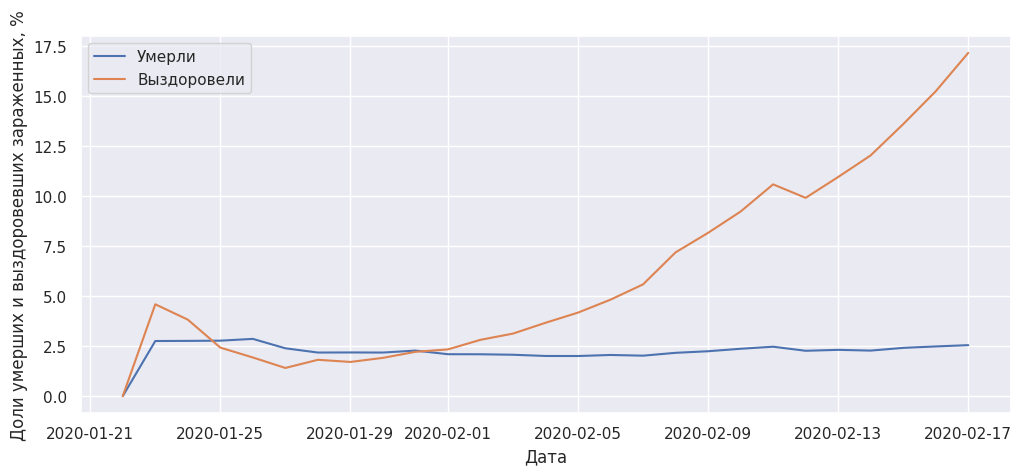

In [16]:
for label in d:
    plt.plot(df_by_date["Date_date"],
             df_by_date[label]/df_by_date['Confirmed']*100,
             label=d[label])

plt.ylabel('Доли умерших и выздоровевших зараженных, %')
plt.xlabel('Дата')
plt.legend()
plt.show()

## Лайнер Diamond Princess

Рассмотрим упоминавшийся частный случай – насколько критично нахождение в замкнутом пространстве круизного лайнера. Сравним, как развивалась ситуация в провинции Хубэй, ставшей очагом распространения болезни с ситуацией в случае карантина на круизном лайнере.

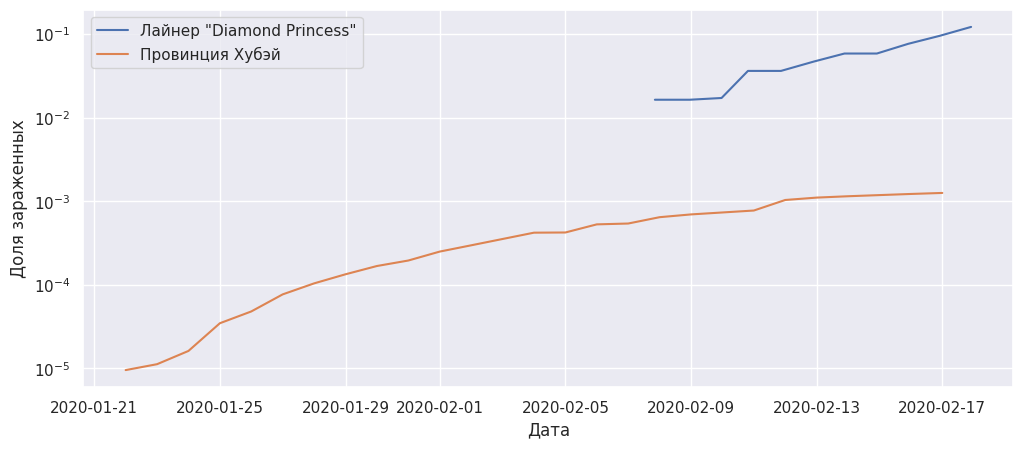

In [17]:
diamond = data[data["Country"]=="Others"]
hubei = data[data["Province/State"]=="Hubei"]


plt.plot(diamond["Date"],
         diamond["Confirmed"]/3700,
         label='Лайнер "Diamond Princess"')

plt.plot(df_by_date["Date_date"],
         df_by_date["Confirmed"]/58e6,
         label="Провинция Хубэй")

plt.yscale('log')

plt.xlabel("Дата")
plt.ylabel("Доля зараженных")
plt.legend()
plt.show()

Чтобы сравнить графики, нам пришлось привести ось ординат к логарифмическому масштабу. Можно видеть, что доля зараженных людей в случае замкнутого пространства круизного лайнера на 1-2 порядка (10-100 раз) превышает процент людей в очаге развития болезни, где люди, несмотря на распространение эпидемии, наказываются в менее тесных условиях, и могут меньше контактировать с заболевшими.

# Заключение

Итак, число случаев заболевания вирусом COVID19 стремительно растёт. Однако это не должно вызывать паники:
1. Очаг вируса имеет локализованный характер. Большинство заболевших сконцентрированы в провинции Китая Хубей. Примерно половина зараженных за пределами Китая это пассажиры и члены команды круизного лайнера Diamond Princess.
2. Текущая летальность вируса по грубой оценке колеблется в диапазоне 2–3%. Для сравнения: летальность другого коронавируса, атипичной пневмонии составляет 9%.  
3. В течение первой недели летальность доминировала над выздоравливаемостью, но сейчас вылечивается всё больше людей.

То есть коронавирус может быть для вас опаснее сезонного гриппа только, если вы находитесь в эпицентре событий.